# whetherChannel Algorithm testing
This notebook outlines the steps for choosing the best-performing algorithm for the whetherChannel project.

### - [Feature Engineering](#fe)
### - [Model specification](#ms)
### - [Testing](#t)


In [1]:
import gzip
import os
import glob
import re
import cPickle
import time

import scipy.stats as ss
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn import ensemble as ske
from sklearn import grid_search as gs
from sklearn import cross_validation as cv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, brier_score_loss
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline 

from sqlalchemy import create_engine
import psycopg2


%matplotlib inline
import matplotlib.pyplot as plt

ImportError: No module named psycopg2

In [13]:
#Change to testing directory, for logs/output
os.chdir('../data/testing')

In [14]:
#Postgres login
un = ''
pw = ''
db = ''
engine = create_engine('postgres://%s:%s@localhost/%s'%(un,pw,db))

In [15]:
#Columns for exclusion
add_ex = ['quadclass', 'goldsteinscale', 'numsources', 'numarticles', 'avgtone']

In [16]:
#Get codebook (type, country, group)
#Recode primary/secondary as type1,type2
recode = {'primary':'type1', 'secondary':'type2', 'tertiary':'type3'}
codes = defaultdict(set)
conn = psycopg2.connect("dbname={} user='{}' password='{}'".format(db,un,pw))
cur = conn.cursor()
cur.execute("""
        select key,type from gd_codebook
        """)
for k in cur.fetchall():
    if k[1] in ('primary','secondary','tertiary'):
        codes['[0-9]type'].add(k[0])
    elif k[1] == 'country':
        codes['[0-9]country'].add(k[0])
    elif k[1] == 'fipscountry':
        codes['geo_country'].add(k[0])
    elif k[1] == 'group':
        codes['group'].add(k[0])
conn.close()

#Add "none" to the codes
for k in codes:
    codes[k].add(None)

#Create sklearn encoder
encodes = {}
encodeKey = {}
for k in codes:
    encodes[k] = LabelEncoder().fit(list(codes[k]))
    
#Pickle encoder
with open('sklearn_encoder.pkl','w') as outfile:
    cPickle.dump(encodes, outfile, cPickle.HIGHEST_PROTOCOL)

## <a name='fe'></a>Feature Engineering

In [17]:
#Read in, process and prepare data for testing
def getdata(since, until, events_t, mentions_t, add_ex = []):
    #Event data
    print "Getting events,",
    df_e = pd.read_sql('''
                    SELECT * FROM {}
                    where cast(dateadded as int)<{}
                    and
                    cast(dateadded as int)>={}
                    '''.format(events_t,until,since),engine)
    df_e.globaleventid = df_e.globaleventid.astype('int64')
    df_e.set_index('globaleventid',inplace=True)
    
    #Mentions data
    print "mentions"
    df_m = pd.read_sql("""
                select globaleventid,
                max(ap) as ap,
                max(huf) as huf,
                max(was) as was,
                max(fox) as fox,
                max(reu) as reu
                from {} group by globaleventid
                """.format(mentions_t),engine)
    df_m.set_index('globaleventid',inplace=True)
    
    #Merge
    df = df_e.join(df_m, how='inner')
    
    #Exclusion columns
    ex = ['globaleventid', 'sourceurl','dateadded','sqldate'] + [x for x in df.columns if (re.search('name',x) is not None) |
               ((re.search('geo_',x) is not None) & (re.search('geo_country',x) is None))]
    ex += ['huf', 'fox', 'ap', 'reu', 'was']
    if add_ex !=[]:
        ex += add_ex
        
    #First pass, for iteration
    features = [x for x in df.columns if (x not in ex)]
    
    #Ensure all observations mention a country/type that's in the codebook
    drops = []
    for k in codes:
        for i in df.filter(regex=k).columns:
            drops += list(df[~df[i].isin(codes[k])].index)
    drops = set(drops)
    
    print "Dropping obs with country/type not in codebook,",
    print "Rows before: {}".format(len(df)),
    df.drop(list(drops),inplace=True)
    print "after: {}".format(len(df))
    
    #List of colnames, by category
    col2code = {}
    #Unique values (for checking encoder completeness)
    vals = defaultdict(list)
    for k in codes:
        for i in list(df_e.filter(regex=k).columns):
            col2code[i] = k
    
    #Encode variables
    print "Encoding"
    remove = []
    for f in features:
        if df[f].dtype not in ('int64', 'float64'):
            if re.search('act',f) is not None:
                #If one of our categories, use label encoder
                if f in col2code:
                    df[f] = encodes[col2code[f]].transform(df[f])
                #Otherwise, Just do cat codes
                else:
                    df[f] = df[f].astype('category').cat.codes
            else:
                df[f] = df[f].astype('float64')
    #Reset index
    df.reset_index(inplace=True)
    return(df, features)

In [7]:
#Read in data
#since/until data for training/validation
since = 20160701
until = 20160831
df, features = getdata(since,until,'gd_eventsb','gd_mentionsb',add_ex = add_ex)

Getting events, mentions
Dropping obs with country/type not in codebook, Rows before: 350110 after: 327560
Encoding


In [18]:
#Create train/test - Test must not have events in train
def traintest(df,features,target):
    eventid = df.globaleventid.unique()
    tr_ids = eventid[np.random.rand(len(eventid)) < 0.8]
    train = df[df.globaleventid.isin(tr_ids)]
    tr_x,tr_y = train[features], train[target] 
    test = df[~df.globaleventid.isin(tr_ids)]
    te_x, te_y = test[features], test[target] 
    return(tr_x,tr_y,te_x,te_y)

## <a name='ms'></a>Model specification

In [9]:
#Network targets
targets = ['huf', 'fox', 'ap', 'reu', 'was']

#Models to use
models = ['RandomForest','GradientBoost','LogisticRegression'] 
params = dict()

#general hyperparameters
njobs = -1
pmetric = 'roc_auc' #Use because class is rare, accuracy wrong metric
verb = 1


#setting up tuning parameters for randomizedsearchcv
params['iter'] = 5 #number of iterations in grid search
params['cvsize'] = 0.5 #fraction of months included in each cross-validation 
params['folds'] = 5 #folds for cross-validation
params['gsub'] = 0.5 #subsample of total dataset size

#RandomForest model parameters
params['RandomForest'] = dict()
params['RandomForest']['n_estimators'] = [2**8] #number of trees in the forest for grid search
params['RandomForest']['max_features'] = ss.beta(a=2,b=15) #number of features to consider at each split
params['RandomForest']['max_leaf_nodes'] = ss.nbinom(n=2,p=0.001,loc=100) #max number of leaves

#GradientBoost model parameters
params['GradientBoost'] = dict()
params['GradientBoost']['loss'] = ['exponential']
params['GradientBoost']['n_estimators'] = ss.nbinom(n=2,p=0.004,loc=100)
params['GradientBoost']['learning_rate'] = ss.beta(a=2,b=25) 
params['GradientBoost']['max_leaf_nodes'] = ss.nbinom(n=3,p=0.2,loc=2) 
params['GradientBoost']['subsample'] = ss.beta(a=4,b=1)
params['GradientBoost']['max_features'] = ss.beta(a=2,b=30)

#LogisticRegression model parameters
params['LogisticRegression'] = dict()
params['LogisticRegression']['penalty'] = 'l2'
params['LogisticRegression']['C'] = ss.beta(a=2,b=25)

## <a name='t'></a>Testing

In [10]:
def gridsearch(data,target,features,model,mparams,labelcol,
               write=False,note=''):
    
    #Get train/test
    x,y = data[features], data[target]
    if 'GradientBoost' in model:
        clf = ske.GradientBoostingClassifier()
        grid = gs.RandomizedSearchCV(clf, 
                    dict(
                        loss=mparams['loss'],
                        n_estimators=mparams['n_estimators'],
                        learning_rate=mparams['learning_rate'],
                        max_leaf_nodes=mparams['max_leaf_nodes'],
                        max_features=mparams['max_features'],
                        subsample=mparams['subsample']
                        ), 
                    scoring=pmetric, n_jobs=njobs, 
                    cv=cv.LabelShuffleSplit(data[labelcol], n_iter=params['folds'], test_size=params['cvsize']), 
                    verbose=verb, refit=False, n_iter=params['iter'])
        
    elif 'RandomForest' in model:
        rf = ske.RandomForestClassifier(criterion='gini', bootstrap=True, n_jobs=1, 
                verbose=0, oob_score=False, class_weight='balanced_subsample')        
        grid = gs.RandomizedSearchCV(rf, 
                    dict(
                        n_estimators=mparams['n_estimators'],
                        max_features=mparams['max_features'],
                        max_leaf_nodes=mparams['max_leaf_nodes']
                        ), 
                    scoring=pmetric, n_jobs=njobs, 
                    cv=cv.LabelShuffleSplit(data[labelcol], n_iter=params['folds'], test_size=params['cvsize']), 
                    verbose=verb, refit=False, n_iter=params['iter'])
    
    elif 'LogisticRegression' in model:
        lr = LogisticRegression(penalty='l2',class_weight='balanced')
        grid = gs.RandomizedSearchCV(lr, 
                    dict(
                        C=mparams['C']
                        ), 
                    scoring=pmetric, n_jobs=njobs, 
                    cv=cv.LabelShuffleSplit(data[labelcol], n_iter=params['folds'], test_size=params['cvsize']), 
                    verbose=verb, refit=False, n_iter=params['iter'])
        
    grid.fit(X=x,y=y)
    
    bp = grid.best_params_
    gperf = []
    for i in range(0,len(grid.grid_scores_)):
        gperf.append(grid.grid_scores_[i][0])
        gperf[i]['perf'] = grid.grid_scores_[i][1].round(4)

    p = pd.DataFrame(gperf)
    print p.sort_values(by='perf', ascending=False)[:20]
    for i in p.columns.drop('perf'):
        p.groupby(pd.qcut(p[i],5)).perf.mean().round(4) 
        print p.groupby(p[i]).perf.mean().round(4)
    print model+' for '+target+' '+time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())
    if write:
        pd.DataFrame(gperf).sort_values(by='perf', ascending=False).to_csv(target+'_'+model+'_perf.csv')
        with open(target+'_best_params.txt', 'a') as f:
            f.write(str(bp)+note+'\n')
    return bp

In [11]:
#Run gridsearch
bpDict = {}
for t in targets:
    for m in models: 
        bpDict[t+m] = gridsearch(df,t,features,m,params[m],'sqldate',
               write=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.4min finished


   max_features  max_leaf_nodes  n_estimators    perf
3      0.185838            1421           256  0.6549
4      0.082877            3178           256  0.6533
1      0.147786             261           256  0.6528
2      0.078079            1180           256  0.6528
0      0.138167            5615           256  0.6498
max_features
0.078079    0.6528
0.082877    0.6533
0.138167    0.6498
0.147786    0.6528
0.185838    0.6549
Name: perf, dtype: float64
max_leaf_nodes
261     0.6528
1180    0.6528
1421    0.6549
3178    0.6533
5615    0.6498
Name: perf, dtype: float64
n_estimators
256    0.6527
Name: perf, dtype: float64
RandomForest for huf Wed, 21 Sep 2016 15:36:20
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.9min finished


   learning_rate         loss  max_features  max_leaf_nodes  n_estimators  \
2       0.162357  exponential      0.063092              11           647   
1       0.073467  exponential      0.070384              10           269   
3       0.032251  exponential      0.050461               6           529   
4       0.029033  exponential      0.035938              13           450   
0       0.010829  exponential      0.059603              22           454   

     perf  subsample  
2  0.6610   0.907596  
1  0.6472   0.644004  
3  0.6467   0.869767  
4  0.6465   0.826585  
0  0.6324   0.949858  
learning_rate
0.010829    0.6324
0.029033    0.6465
0.032251    0.6467
0.073467    0.6472
0.162357    0.6610
Name: perf, dtype: float64
loss
exponential    0.6468
Name: perf, dtype: float64
max_features
0.035938    0.6465
0.050461    0.6467
0.059603    0.6324
0.063092    0.6610
0.070384    0.6472
Name: perf, dtype: float64
max_leaf_nodes
6     0.6467
10    0.6472
11    0.6610
13    0.6465
22    0

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.3min finished


          C    perf
2  0.009623  0.5990
0  0.055753  0.5978
3  0.017744  0.5962
1  0.142477  0.5955
4  0.050815  0.5952
C
0.009623    0.5990
0.017744    0.5962
0.050815    0.5952
0.055753    0.5978
0.142477    0.5955
Name: perf, dtype: float64
LogisticRegression for huf Wed, 21 Sep 2016 15:43:32
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  8.9min finished


   max_features  max_leaf_nodes  n_estimators    perf
2      0.063056             966           256  0.6294
1      0.119851            1660           256  0.6280
3      0.099695             305           256  0.6257
0      0.032315            1362           256  0.6219
4      0.249845            5247           256  0.6215
max_features
0.032315    0.6219
0.063056    0.6294
0.099695    0.6257
0.119851    0.6280
0.249845    0.6215
Name: perf, dtype: float64
max_leaf_nodes
305     0.6257
966     0.6294
1362    0.6219
1660    0.6280
5247    0.6215
Name: perf, dtype: float64
n_estimators
256    0.6253
Name: perf, dtype: float64
RandomForest for fox Wed, 21 Sep 2016 15:52:28
Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

### Output model auc

In [166]:
def aucplt(data, best_params,features,target,save=False):
    tr_x,tr_y,te_x,te_y = traintest(data,features,target)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    
    for i in best_params:
        m = None
        if i == target+'RandomForest':
            m = ske.RandomForestClassifier(n_estimators=best_params[i]['n_estimators'], 
                max_features=best_params[i]['max_features'], 
                max_leaf_nodes=best_params[i]['max_leaf_nodes'],
                criterion='gini', bootstrap=True, n_jobs=njobs,
                oob_score=False, class_weight='balanced_subsample')
        elif i == target+'GradientBoost':
            m = ske.GradientBoostingClassifier(loss=best_params[i]['loss'],
                n_estimators=best_params[i]['n_estimators'], learning_rate=best_params[i]['learning_rate'],
                max_leaf_nodes=best_params[i]['max_leaf_nodes'],subsample=best_params[i]['subsample'])
        elif i == target+'LogisticRegression':
            m = LogisticRegression(penalty='l2',class_weight='balanced', C = best_params[i]['C'])
        if m is not None:
            fit_m = m.fit(tr_x,tr_y)
            m_pred = m.predict_proba(te_x)[:, 1]
            fpr_m, tpr_m, _ = roc_curve(te_y, m_pred)
            plt.plot(fpr_m, tpr_m, label=i)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for '+target)
    plt.legend(loc='best')
    
    if save:
        fig.savefig(target+'_roc.png')
    plt.show()

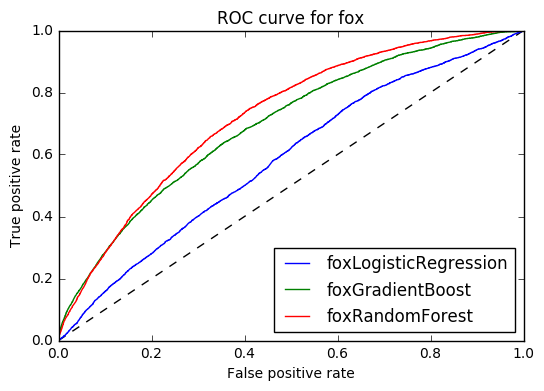

In [167]:
for t in target:
    aucplt(df,bpDict,features,t,save=True)

### Run best model, pickle

In [372]:
def runmodel(data,best_params, features, target, models):
    base = 0.5
    
    for m in models:
        if best_params[target+m]['perf']>base:
            base = best_params[target+m]['perf']
            best = m
    
    if best == 'RandomForest':
        m = ske.RandomForestClassifier(n_estimators=best_params[target+best]['n_estimators'], 
            max_features=best_params[target+best]['max_features'], 
            max_leaf_nodes=best_params[target+best]['max_leaf_nodes'],
            criterion='gini', bootstrap=True, n_jobs=njobs,
            oob_score=False, class_weight='balanced_subsample')
    elif best == 'GradientBoost':
        m = ske.GradientBoostingClassifier(loss=best_params[target+best]['loss'],
            n_estimators=best_params[target+best]['n_estimators'], learning_rate=best_params[target+best]['learning_rate'],
            max_leaf_nodes=best_params[target+best]['max_leaf_nodes'],subsample=best_params[target+best]['subsample'])
    elif best == 'LogisticRegression':
        m = LogisticRegression(penalty='l2',class_weight='balanced', C = best_params[target+best]['C'])
    
    fit_m = m.fit(data[features],data[target])
    
    with open(target+'_'+best+'_model.pkl','wb') as model_file:
        cPickle.dump(m, model_file, cPickle.HIGHEST_PROTOCOL)
    
    return(fit_m)

In [373]:
for t in targets:
    runmodel(df,bpDict,features,t,models)